## Server

## 1. Import libraries.

In [1]:
from flask import *
from flask_cors import CORS
from werkzeug.utils import secure_filename
import os
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util


## 2. Enter trained model, load config file and build a detection model.
Function loads model.

In [2]:
model = "malpytest13"

In [3]:
configs = config_util.get_configs_from_pipeline_file(os.path.join('models', model, 'pipeline.config'))
detection_model = model_builder.build(model_config=configs['model'], is_training=False)
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join('models', model, 'ckpt-4')).expect_partial()

category_index = label_map_util.create_category_index_from_labelmap(os.path.join('annotations', 'label_map.pbtxt'))

## 3. Image detection.
Pre-trained detection function.

In [4]:
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

## 4. Object detection.
This functions takes the image and runs object detection on it using pre-trained detection function. After completing detection process the funtions returns class of the detected object.

In [5]:
def rec(IMAGE_PATH):
    img = cv2.imread(IMAGE_PATH)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.4,
                agnostic_mode=False)

    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    #plt.savefig("mygraph.png")
    outcome = detections["detection_classes"][0]+1
    #print(outcome)
    return outcome
    #plt.show()

## 5. Create a folder, to which the server uploads files, allow selected image extensions.
The server only allows image file to be processed. The allowed_file function checks if the file has a correct extension.

In [6]:
UPLOAD_FOLDER = "./uploads"
ALLOWED_EXTENSIONS = {'png', 'jpeg', 'jpg'}
app = Flask(__name__, static_folder='../client/src')
CORS(app)
app.config["UPLOAD_FOLDER"] = UPLOAD_FOLDER

In [7]:
def allowed_file(filename):
    return '.' in filename and \
        filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

## 6. Main server function.
Here the server checks if the user sent the correct file, if the correct file is provided it gets saved and processed by tensorflow. Then tensorflow indentifies a monkey, removes the file and reroutes user to the detected monkey's page.

In [8]:
@app.route("/upload", methods=["POST", "GET"])
def upload():
    if request.method == 'POST':
        if 'file' not in request.files:
            data = {"message": 0, "monkey" : 0}
            return jsonify(data)
        file = request.files['file']
        if file.filename == '':
            data = {"message": 0, "monkey" : 0}
            return jsonify(data)
        if file and allowed_file(file.filename):
            filename = secure_filename(file.filename)
            path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
            file.save(path)
            monkey_id = rec(path)
            print(monkey_id)
            data = {"message": 1, "monkey" : int(monkey_id)}
            os.remove(os.path.join(app.config['UPLOAD_FOLDER'], filename))
            return jsonify(data)

In [ ]:
if __name__ == "__main__":
    app.run(port=3000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:3000
Press CTRL+C to quit
127.0.0.1 - - [26/Jan/2023 16:27:13] "OPTIONS /upload HTTP/1.1" 200 -


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


127.0.0.1 - - [26/Jan/2023 16:27:34] "POST /upload HTTP/1.1" 200 -


3


127.0.0.1 - - [26/Jan/2023 16:27:49] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:27:54] "POST /upload HTTP/1.1" 200 -


2


127.0.0.1 - - [26/Jan/2023 16:28:04] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:28:10] "POST /upload HTTP/1.1" 200 -


1


127.0.0.1 - - [26/Jan/2023 16:28:29] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:28:35] "POST /upload HTTP/1.1" 200 -


5


127.0.0.1 - - [26/Jan/2023 16:28:42] "OPTIONS /upload HTTP/1.1" 200 -


127.0.0.1 - - [26/Jan/2023 16:28:48] "POST /upload HTTP/1.1" 200 -


2


127.0.0.1 - - [26/Jan/2023 16:28:58] "OPTIONS /upload HTTP/1.1" 200 -


127.0.0.1 - - [26/Jan/2023 16:29:04] "POST /upload HTTP/1.1" 200 -


5


127.0.0.1 - - [26/Jan/2023 16:29:18] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:29:18] "POST /upload HTTP/1.1" 200 -


1


127.0.0.1 - - [26/Jan/2023 16:29:37] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:29:43] "POST /upload HTTP/1.1" 200 -


2


127.0.0.1 - - [26/Jan/2023 16:29:54] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:29:54] "POST /upload HTTP/1.1" 200 -


1


127.0.0.1 - - [26/Jan/2023 16:30:22] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:30:27] "POST /upload HTTP/1.1" 200 -


5


127.0.0.1 - - [26/Jan/2023 16:30:38] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:30:44] "POST /upload HTTP/1.1" 200 -


5


127.0.0.1 - - [26/Jan/2023 16:31:25] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:31:31] "POST /upload HTTP/1.1" 200 -


1


127.0.0.1 - - [26/Jan/2023 16:31:38] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:31:43] "POST /upload HTTP/1.1" 200 -


5


127.0.0.1 - - [26/Jan/2023 16:32:03] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:32:04] "POST /upload HTTP/1.1" 200 -


2


127.0.0.1 - - [26/Jan/2023 16:32:11] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:32:17] "POST /upload HTTP/1.1" 200 -


2


127.0.0.1 - - [26/Jan/2023 16:32:22] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:32:28] "POST /upload HTTP/1.1" 200 -


1


127.0.0.1 - - [26/Jan/2023 16:33:14] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:33:19] "POST /upload HTTP/1.1" 200 -


2


127.0.0.1 - - [26/Jan/2023 16:33:44] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:33:50] "POST /upload HTTP/1.1" 200 -


1


127.0.0.1 - - [26/Jan/2023 16:37:02] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:37:02] "POST /upload HTTP/1.1" 200 -


1


127.0.0.1 - - [26/Jan/2023 16:37:08] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:37:08] "POST /upload HTTP/1.1" 200 -


2


127.0.0.1 - - [26/Jan/2023 16:37:27] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:37:32] "POST /upload HTTP/1.1" 200 -


1


127.0.0.1 - - [26/Jan/2023 16:37:48] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:37:54] "POST /upload HTTP/1.1" 200 -


3


127.0.0.1 - - [26/Jan/2023 16:38:05] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:38:06] "POST /upload HTTP/1.1" 200 -


2


127.0.0.1 - - [26/Jan/2023 16:39:14] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:39:15] "POST /upload HTTP/1.1" 200 -


2


127.0.0.1 - - [26/Jan/2023 16:39:23] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:39:29] "POST /upload HTTP/1.1" 200 -


1


127.0.0.1 - - [26/Jan/2023 16:39:49] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:39:55] "POST /upload HTTP/1.1" 200 -


4


127.0.0.1 - - [26/Jan/2023 16:40:07] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:40:12] "POST /upload HTTP/1.1" 200 -


4


127.0.0.1 - - [26/Jan/2023 16:40:19] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:40:19] "POST /upload HTTP/1.1" 200 -


4


127.0.0.1 - - [26/Jan/2023 16:40:40] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:40:45] "POST /upload HTTP/1.1" 200 -


4


127.0.0.1 - - [26/Jan/2023 16:41:13] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:41:13] "POST /upload HTTP/1.1" 200 -


2


127.0.0.1 - - [26/Jan/2023 16:41:35] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:41:36] "POST /upload HTTP/1.1" 200 -


2


127.0.0.1 - - [26/Jan/2023 16:41:41] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:41:47] "POST /upload HTTP/1.1" 200 -


2


127.0.0.1 - - [26/Jan/2023 16:41:52] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:41:58] "POST /upload HTTP/1.1" 200 -


2


127.0.0.1 - - [26/Jan/2023 16:42:05] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:42:11] "POST /upload HTTP/1.1" 200 -


1


127.0.0.1 - - [26/Jan/2023 16:42:21] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:42:21] "POST /upload HTTP/1.1" 200 -


2


127.0.0.1 - - [26/Jan/2023 16:43:34] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:43:35] "POST /upload HTTP/1.1" 200 -


1


127.0.0.1 - - [26/Jan/2023 16:43:42] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:43:42] "POST /upload HTTP/1.1" 200 -


5


127.0.0.1 - - [26/Jan/2023 16:43:50] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:43:51] "POST /upload HTTP/1.1" 200 -


5


127.0.0.1 - - [26/Jan/2023 16:43:55] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:43:56] "POST /upload HTTP/1.1" 200 -


2


127.0.0.1 - - [26/Jan/2023 16:44:01] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:44:06] "POST /upload HTTP/1.1" 200 -


5


127.0.0.1 - - [26/Jan/2023 16:44:27] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:44:27] "POST /upload HTTP/1.1" 200 -


5


127.0.0.1 - - [26/Jan/2023 16:44:32] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:44:38] "POST /upload HTTP/1.1" 200 -


2


127.0.0.1 - - [26/Jan/2023 16:44:44] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:44:45] "POST /upload HTTP/1.1" 200 -


1


127.0.0.1 - - [26/Jan/2023 16:45:08] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:45:09] "POST /upload HTTP/1.1" 200 -


2


127.0.0.1 - - [26/Jan/2023 16:45:18] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:45:23] "POST /upload HTTP/1.1" 200 -


2


127.0.0.1 - - [26/Jan/2023 16:45:35] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:45:35] "POST /upload HTTP/1.1" 200 -


2


127.0.0.1 - - [26/Jan/2023 16:45:41] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:45:42] "POST /upload HTTP/1.1" 200 -


5


127.0.0.1 - - [26/Jan/2023 16:45:50] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:45:51] "POST /upload HTTP/1.1" 200 -


1


127.0.0.1 - - [26/Jan/2023 16:47:03] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:47:03] "POST /upload HTTP/1.1" 200 -


1


127.0.0.1 - - [26/Jan/2023 16:48:16] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 16:48:16] "POST /upload HTTP/1.1" 200 -


4


127.0.0.1 - - [26/Jan/2023 17:03:45] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 17:03:45] "POST /upload HTTP/1.1" 200 -


4


127.0.0.1 - - [26/Jan/2023 17:05:20] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2023 17:05:20] "POST /upload HTTP/1.1" 200 -


2


## 7. Diagram of the process

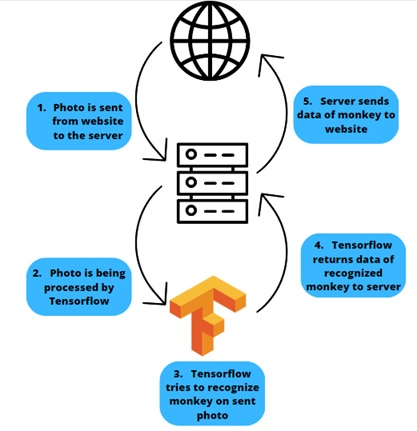